# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [188]:
%matplotlib inline
import warnings

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [17]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 
# for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [18]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [19]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [20]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [21]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [22]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [23]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [24]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [25]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [26]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [27]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [28]:
final = final[:50000]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(50000, 10)


1    41785
0     8215
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [29]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [30]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [31]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [32]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [33]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he has not had a UTI for a year.


In [34]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [35]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My husband is a paraplegic and was having UTIs constantly Since he started drinking a cup of this tea every morning he has not had a UTI for a year 


In [36]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [37]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2531.60it/s]


In [38]:
preprocessed_reviews[1500]

'husband paraplegic utis constantly since started drinking cup tea every morning not uti year'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 41655)
the number of unique words  41655


## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.4] Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8427783250808716), ('fantastic', 0.8190776705741882), ('good', 0.7952964305877686), ('excellent', 0.7924747467041016), ('terrific', 0.789459764957428), ('perfect', 0.7546799182891846), ('wonderful', 0.7473049759864807), ('amazing', 0.7376190423965454), ('fabulous', 0.7095903754234314), ('nice', 0.6640677452087402)]
[('nastiest', 0.7221115827560425), ('greatest', 0.7200913429260254), ('best', 0.7127593755722046), ('tastiest', 0.6972683668136597), ('ive', 0.653144121170044), ('experienced', 0.6495607495307922), ('awful', 0.6415215134620667), ('horrible', 0.6289716362953186), ('hardly', 0.6189676523208618), ('terrible', 0.6063140034675598)]


In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13431
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:24<00:00, 588.98it/s]


50000
50


In [48]:
import pickle
with open('tfidf_sent_vectors.pkl', 'wb') as f:
    pickle.dump(tfidf_sent_vectors, f)

#### [4.4.1.2] TFIDF weighted W2v

In [46]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [14:58<00:00, 55.66it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:30:58<00:00, 619.44s/it]


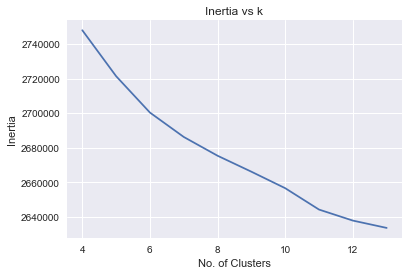

In [35]:
k_range = np.arange(4,14)
inertia = []
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(final_counts)
    inertia.append(kmeans.inertia_)

#plt.style.use('seaborn-white')
plt.grid('on')
plt.plot(k_range, inertia)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs k')
plt.show()

Considering the slightly higher change in slope at k = 6, as compared to other values of k, we can approximate the optimal value of clusters k to be 6.

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

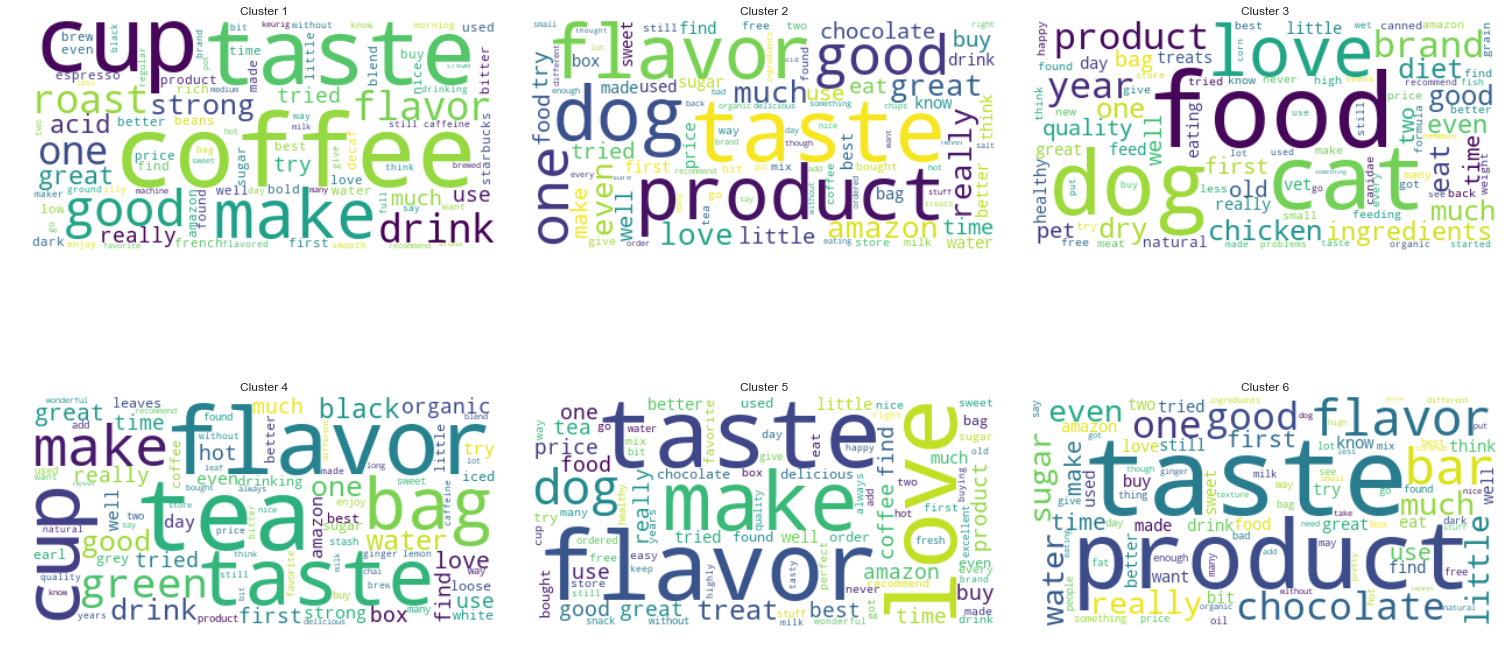

In [64]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
warnings.filterwarnings("ignore")
k = 6
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
kmeans.fit(final_counts)
plt.figure(figsize=(21, 21))
for i in range(k):
    samples = final_counts.tocsr()[np.where(kmeans.labels_ == i)[0], :]
    sum_words = samples.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
    words_freq =list(dict(sorted(words_freq, key = lambda x: x[1], reverse=True)[:100]).keys())
    plt.subplot(4, 3, i+1)
    wordcloud = WordCloud(background_color="white").generate(" ".join(words_freq))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.title('Cluster ' + str(i+1))
plt.show()

We can see that the clusters here roughly represent the following:<br>
<b>Cluster 1 :</b> Represents mostly reviews related to coffee and how they taste.<br>
<b>Cluster 2 :</b> Probably deals with dog food reviews and how well the pet dogs liked them.<br>
<b>Cluster 3 :</b> Includes reviews of both dog and cat food, their quality and ingredients.<br>
<b>Cluster 4 :</b> Deals with reviews of different types of teas, like black, green, iced, and their taste and flavor.<br>
<b>Cluster 5 :</b> Again includes reviews of mostly dog food like treats, their prices, flavor and how well their pets loved them.<br>
<b>Cluster 6 :</b> Represents reviews about sweets and chocolates,both bars of chocolate and chocolate drinks perhaps, and their taste.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 10/10 [1:42:21<00:00, 706.06s/it]


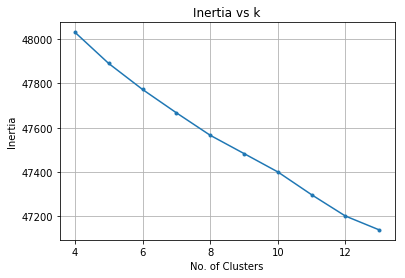

In [3]:
k_range = np.arange(4,14)
inertia = []
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(final_tf_idf)
    inertia.append(kmeans.inertia_)

# plt.style.use('seaborn-white')
plt.grid('on')
plt.plot(k_range, inertia, marker='.')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs k')
plt.show()

Considering the slight change in slope at k = 8, as compared to other values of k, we can approximate the optimal value of clusters k to be 8.

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

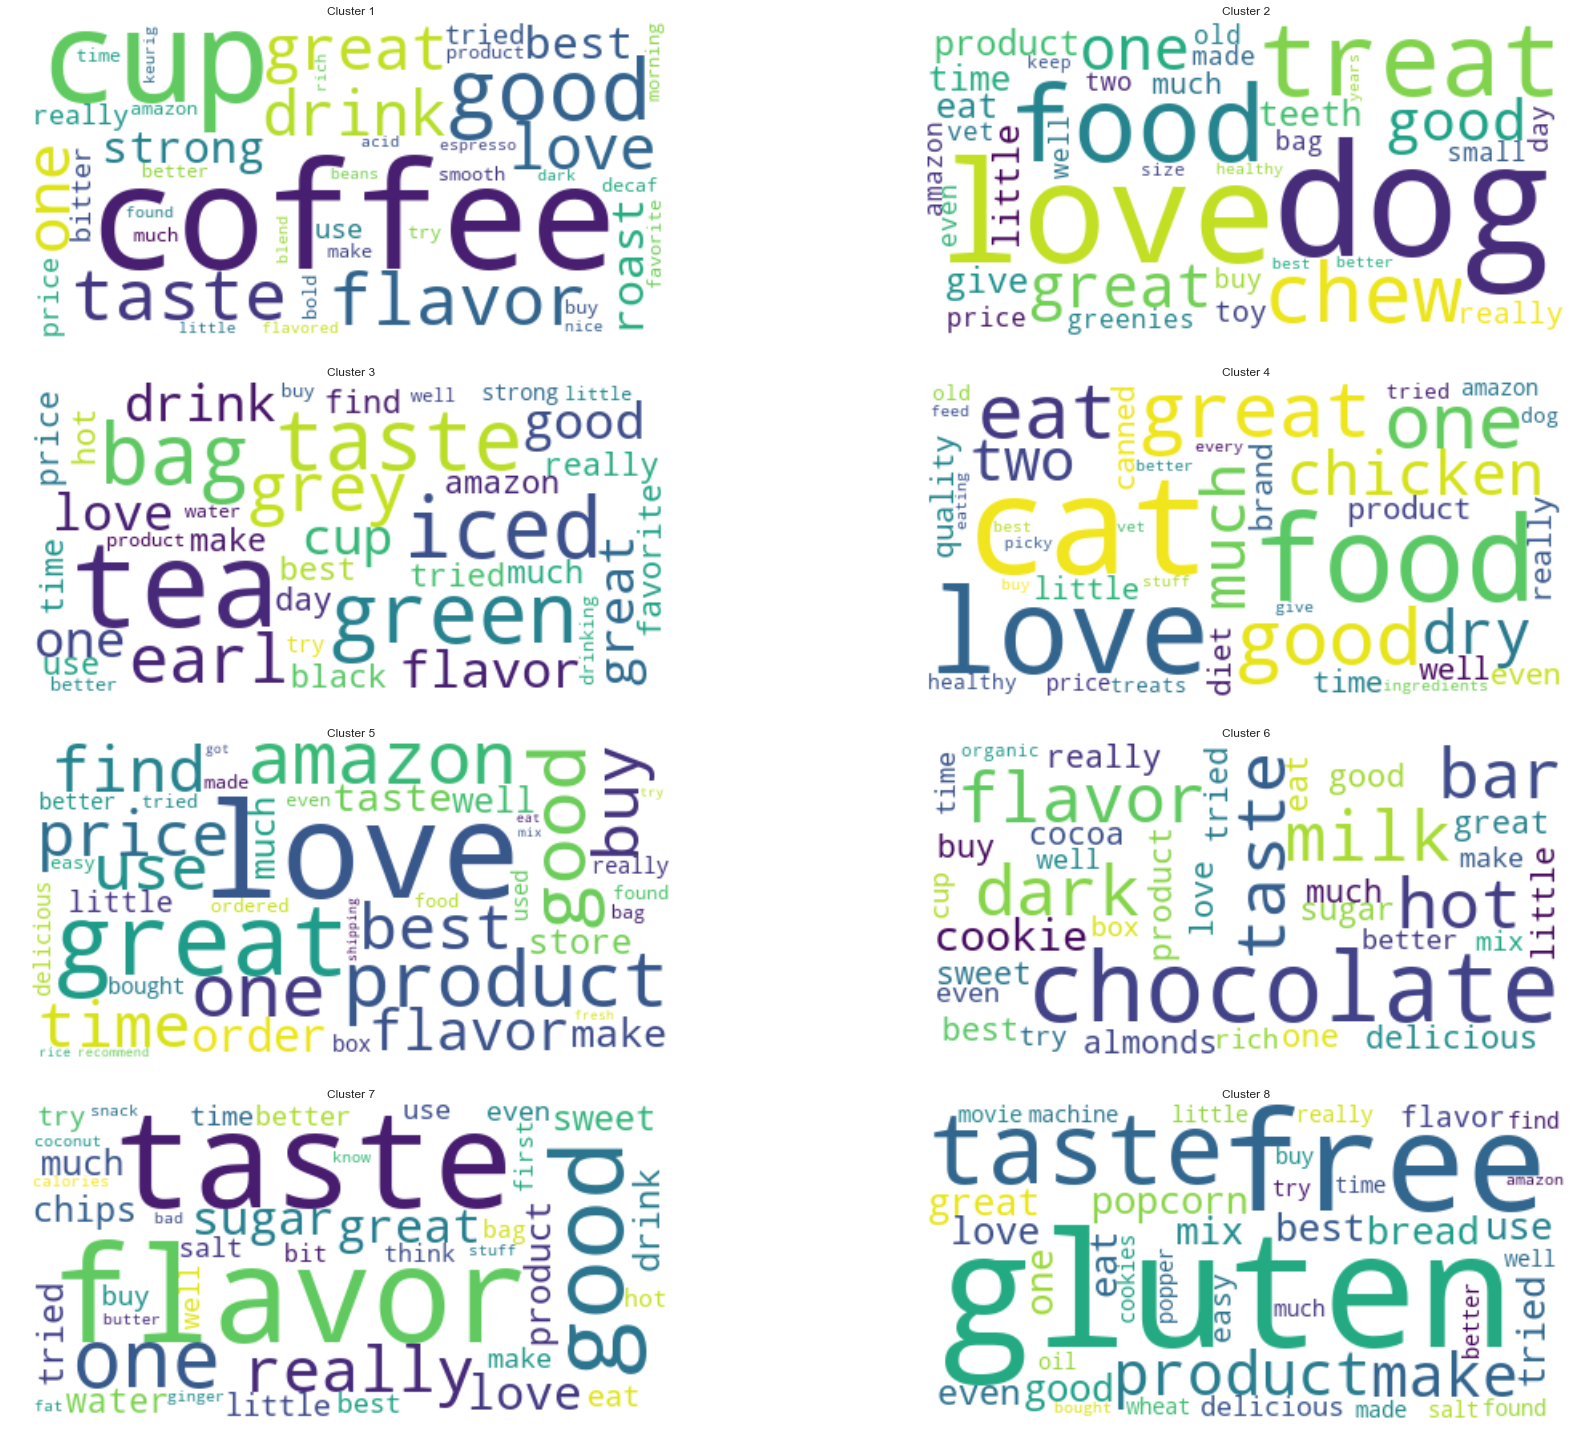

In [208]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
kmeans.fit(final_tf_idf)
plt.figure(figsize=(25, 25))
for i in range(k):
    samples = [" ".join(list_of_sentance[j]) for j in np.where(kmeans.labels_ == i )[0]]
    # Fetch 500 most important words from the cluster
    words = imp_words(samples, 50)
    plt.subplot(5, 2, i+1)
    # Plot thw Wordcloud
    wordcloud = WordCloud(background_color="white").generate(words)#" ".join(words))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.title('Cluster ' + str(i+1))
plt.show()

We can see that the clusters here roughly represent the following:<br>
<b>Cluster 1 :</b> Represents reviews about different types of coffee like espresso black and decaf, and their attributes, like their roasting, bitterness, taste and flavor.<br>
<b>Cluster 2 :</b> Deals with dog food and treat reviews and dog toys too and how well the pet dogs liked them.<br>
<b>Cluster 3 :</b> Deals with reviews of different types of teas, like black, green, iced, earl grey and their taste and flavor.<br>
<b>Cluster 4 :</b> Deals wit reviews of cat food, their ingreidients like chicken, their varities lke canned or treats, and how well they are loved by their pet cats.<br>
<b>Cluster 5 :</b> Probably talks about their experience with food products ordered from amazon, as compared to store-purcahsed items, and things like proce, shipping times, etc.<br>
<b>Cluster 6 :</b> Includes reviews of different chocolates and chocolate products, like dark and milk chocolates, cocoa powder, etc. <br>
<b>Cluster 7 :</b> Probably represents reviews of snacks like chips, drinks and sweets and their calories, ingredients, taste, sugar content, etc.<br>
<b>Cluster 8 :</b> Probably talks of health aspects of bread, like gluten content, salt content, wheat content, as well as popcorn and its taste.

#### Function to get n important points based on TFIDF

In [200]:
## Get n_words important words based on TFIDF from a list of strings
# https://stackoverflow.com/a/46505500/9327239
def imp_words(list_str, n_words):
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    list_str = tfidf.fit_transform(list_str)
    terms = tfidf.get_feature_names()

    # sum tfidf frequency of each term through documents
    sums = list_str.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append((term, sums[0,col] ))
    ranking = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
#     pdb.set_trace()
    ranking.head()
    return " ".join(ranking[:n_words]['term'])

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:50<00:00,  6.21s/it]


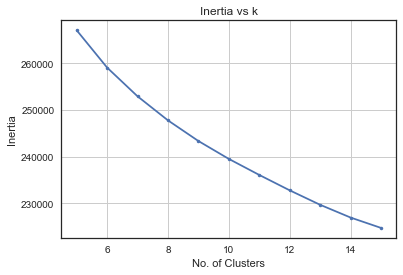

In [68]:
k_range = np.arange(5,16)
inertia = []
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(sent_vectors)
    inertia.append(kmeans.inertia_)

plt.style.use('seaborn-white')
plt.grid('on')
plt.plot(k_range, inertia, marker='.')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs k')
plt.show()

Considering the slight change in slope at k = 8, as compared to other values of k, we can approximate the optimal value of clusters k to be 8.

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

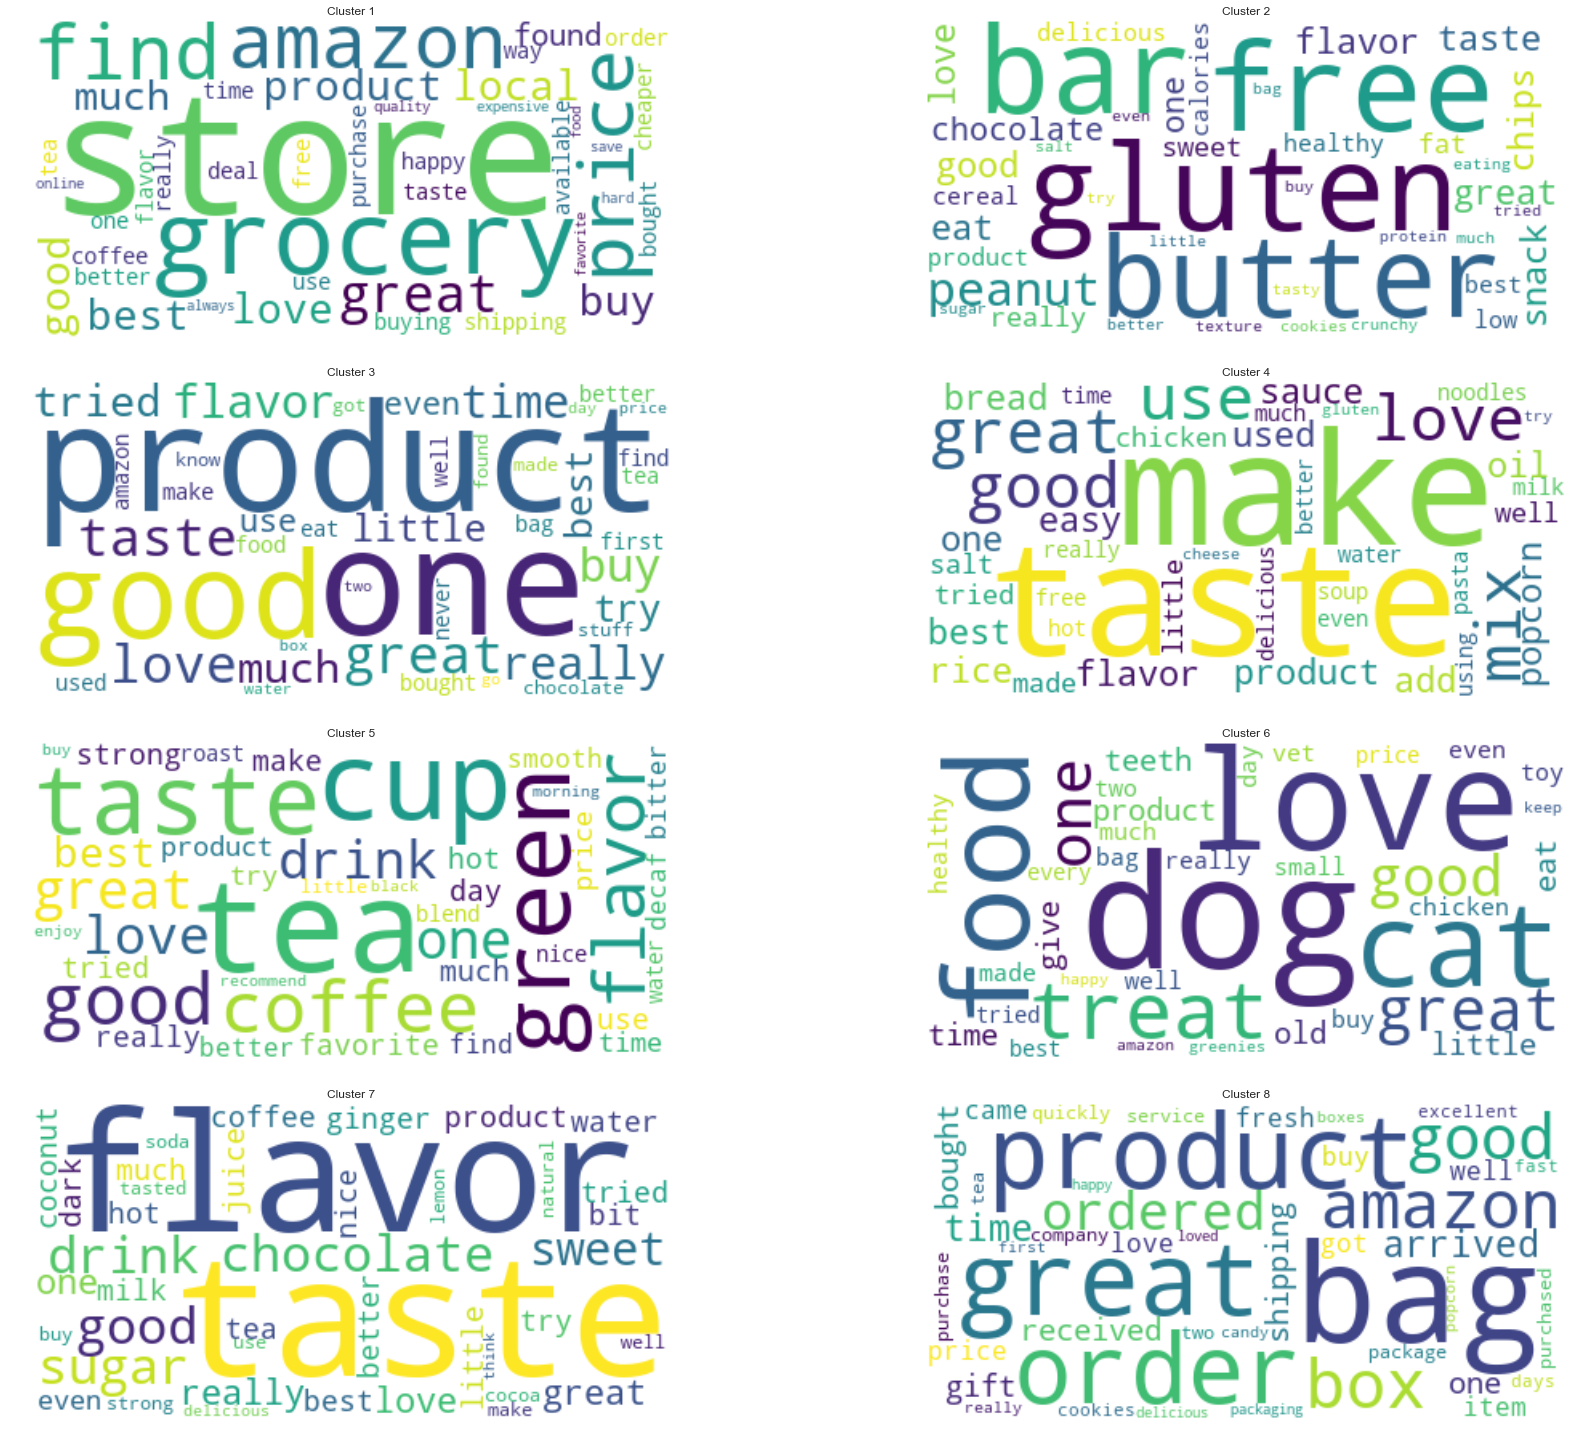

In [201]:
## https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
# Run KMeans with 8 clusters as an optimal number of clusters
k = 8
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
kmeans.fit(sent_vectors)
count_vect = CountVectorizer()
plt.figure(figsize=(25, 25))
for i in range(k):
    samples = [" ".join(list_of_sentance[j]) for j in np.where(kmeans.labels_ == i )[0]]
    # Extract 50 most important words of the cluster using TFIDF
    words = imp_words(samples, 50)
    plt.subplot(5, 2, i+1)
    # Plot Wordcloud on the frequently occuring words of the cluster
    wordcloud = WordCloud(background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.title('Cluster ' + str(i+1))
plt.show()

We can see that the clusters here roughly represent the following:<br>
<b>Cluster 1 :</b> Deals with reviews which probably compare the price and other aspects of products between amazon and local stores.<br>
<b>Cluster 2 :</b> Represents reviews of snacks, cereal, peanut butter, and their health aspects like being gluten free and calorie content, and things like sweetness, texture, and taste.<br>
<b>Cluster 3 :</b> Is not a very distinct cluster, and probably includes just taste and quality aspects of some food items.<br>
<b>Cluster 4 :</b> Probably includes mostly reviews of packaged recipes, like popcorn and some premixed items, and their ease of making, taste, and stuff the customers like to add while making them at home.<br>
<b>Cluster 5 :</b> Deals mostly with different types of teas, and to a lesser extent about some coffees, with reviews on their taste and flavor.<br>
<b>Cluster 6 :</b> Represents mostly pet food reviews for dogs and cats, their ingredients like chicken, how healthy they are, and how much their pets like them.<br>
<b>Cluster 7 :</b> Includes reviews on Chocolate drinks and products, their flavor and taste, and in what form the customers like to have them.<br>
<b>Cluster 8 :</b> Probably represents reviews which talk about packaging of ithe items purchased from Amazon, the shipping speed, gift packing, and how well they liked these aspects of their purchase.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  5.44s/it]


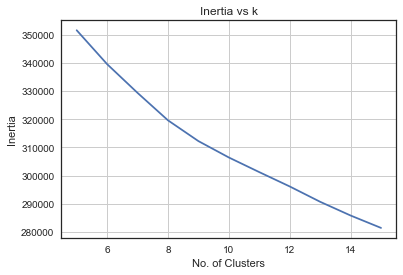

In [132]:
k_range = np.arange(5,16)
inertia = []
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(tfidf_sent_vectors)
    inertia.append(kmeans.inertia_)

plt.style.use('seaborn-white')
plt.grid('on')
plt.plot(k_range, inertia)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs k')
plt.show()

Considering the slight change in slope at k = 9, as compared to other values of k, we can approximate the optimal value of clusters k to be 9.

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

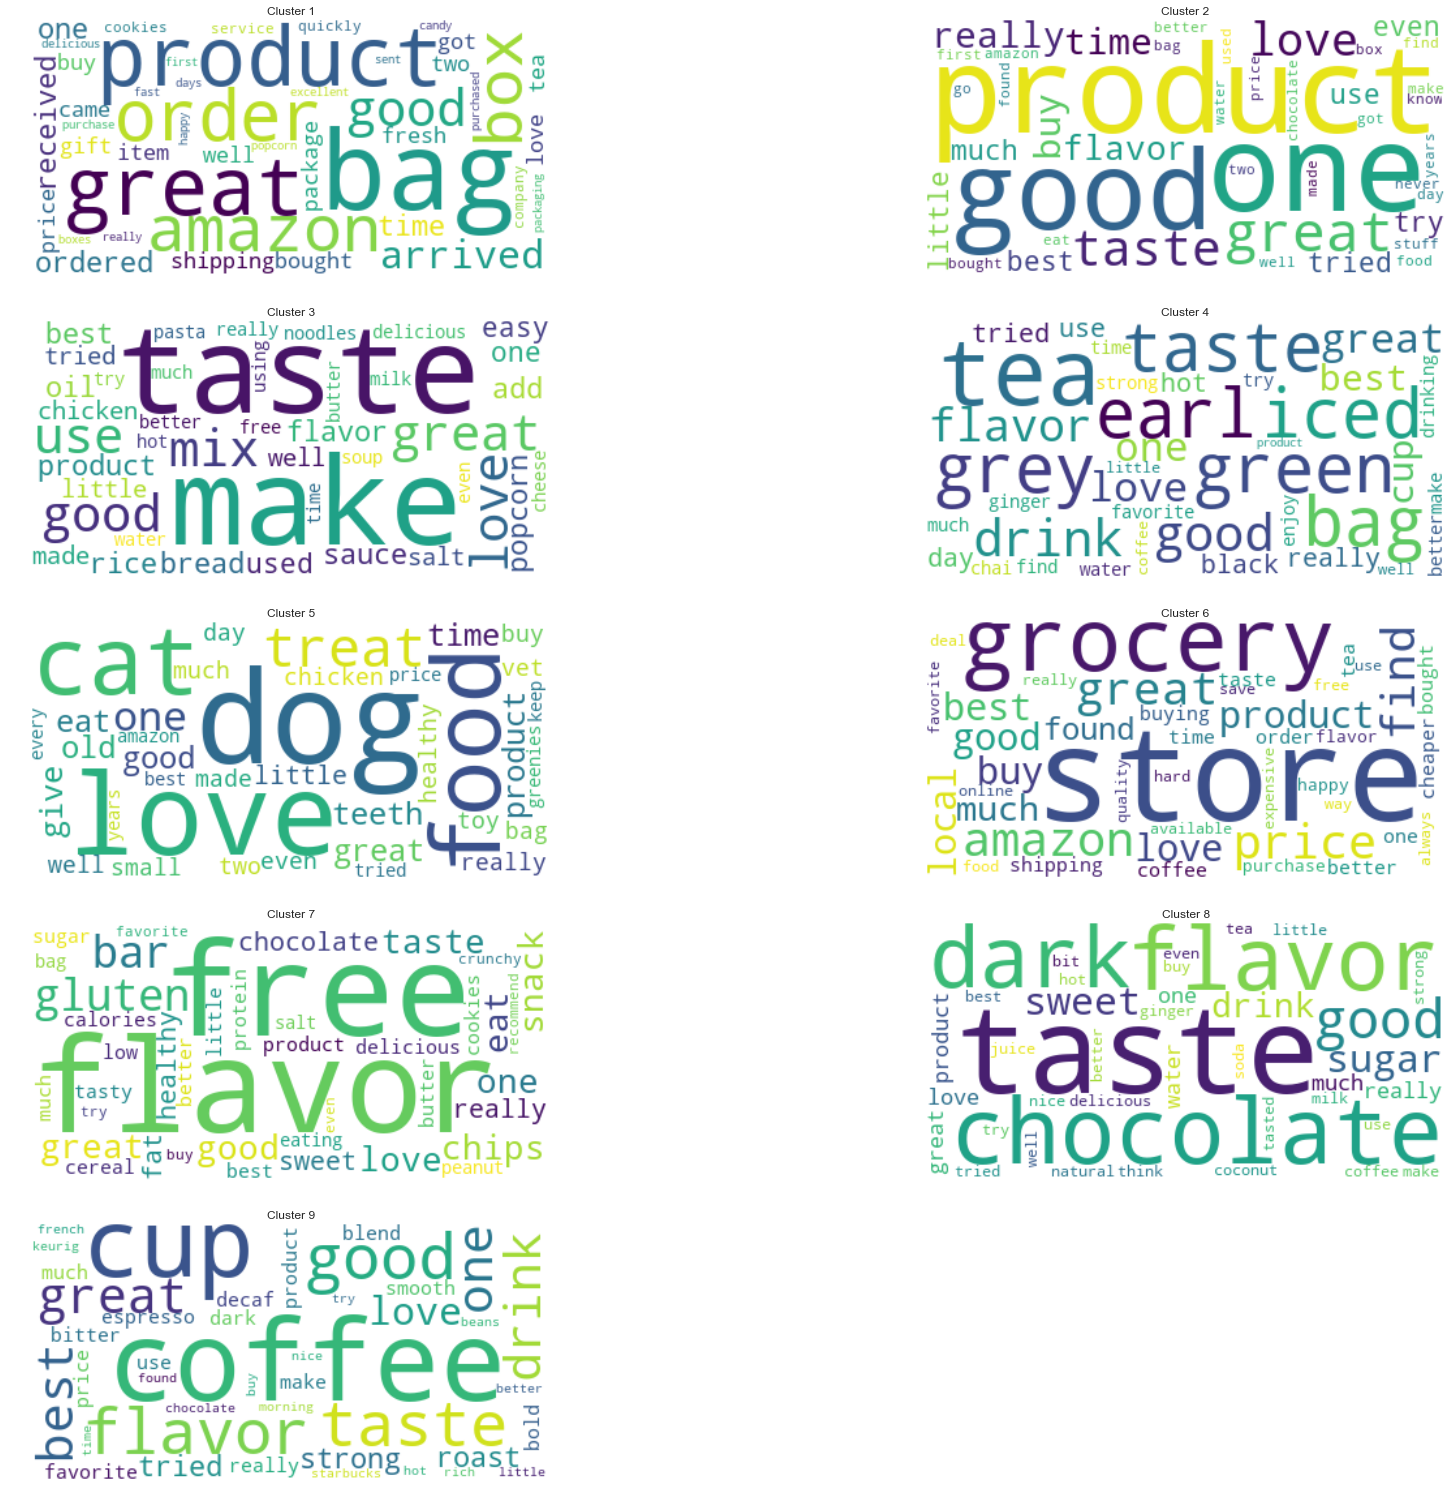

In [148]:
# Run KMeans with 9 clusters
k = 9
import pdb
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
kmeans.fit(sent_vectors)
plt.figure(figsize=(25, 25))
for i in range(k):
    samples = [" ".join(list_of_sentance[j]) for j in np.where(kmeans.labels_ == i )[0]]
    # Fetch 500 most important words from the cluster
    words = imp_words(samples, 50)
    plt.subplot(6, 2, i+1)
    # Plot thw Wordcloud
    wordcloud = WordCloud(background_color="white").generate(words)#" ".join(words))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.title('Cluster ' + str(i+1))
plt.show()

We can see that the clusters here roughly represent the following:<br>
<b>Cluster 1 :</b> Represents reviews which talk about what the customers liked about their purchase from Amazon, like packaging of the items purchased, the shipping speed, price, gift packing etc.<br>
<b>Cluster 2 :</b> Includes reviews which talk about the generic taste aspects of the food items purchased.<br>
<b>Cluster 3 :</b> Includes reviews of staples like bread, rice, pasta, noodles, and ready to cook stuff like popcorn and premixes, alongwith recipes which the customers like to make with them.<br>
<b>Cluster 4 :</b> Represents specifically diffferent types of teas, like chai, earl gery, green tea, black tea, tea bags, and their taste.<br>
<b>Cluster 5 :</b> Represents mostly pet food reviews, and how much their pets like them.<br>
<b>Cluster 6 :</b> Represents reviews which compare grocery products purchased from local stores with those purchased from Amazon, and which one they like better.<br>
<b>Cluster 7 :</b> Has taste reviews of snacks like chips and some chocolate bars, alongwith their crunchiness, and health aspects like fat, sugar, gulten and calorie content.<br>
<b>Cluster 8 :</b> Deals mostly with Chocolate and their types, flavor and taste, and how the customers like to have them.<br>
<b>Cluster 9 :</b> Deals mostly with different types of coffees, with reviews on their taste and flavor.<br>

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [202]:
k1 = 2; k2 = 5; n_samples = 10000; n_words = 50
agg1 = AgglomerativeClustering(n_clusters=k1)
labels_1 = agg1.fit_predict(sent_vectors[:n_samples])

agg2 = AgglomerativeClustering(n_clusters=k2)
labels_2 = agg2.fit_predict(sent_vectors[:n_samples])

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [185]:
def plot_wordclouds(list_sent, labels, n_clusters, n=50):
    plt.figure(figsize=(20, 20))
    for i in range(n_clusters):
        samples = [" ".join(list_sent[j]) for j in np.where(labels == i)[0]]
        # Extract n most frequent words of the cluster using Bag of Words
        vec = CountVectorizer()
        samples = vec.fit_transform(samples)
        sum_words = samples.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =list(dict(sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]).keys())
        plt.subplot(int(n_clusters/2) + 2, 2, i+1)
        # Plot Wordcloud on the frequently occuring words of the cluster
        wordcloud = WordCloud(background_color="white").generate(" ".join(words_freq))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout()
        plt.title('Cluster ' + str(i+1))
    plt.show()

Wordclouds for 2 clusters


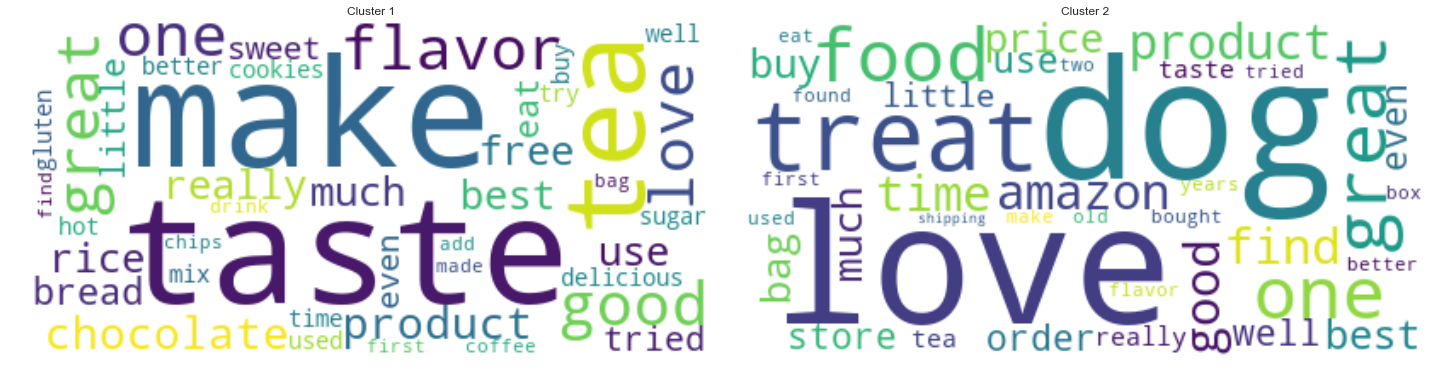

Wordclouds for 5 clusters


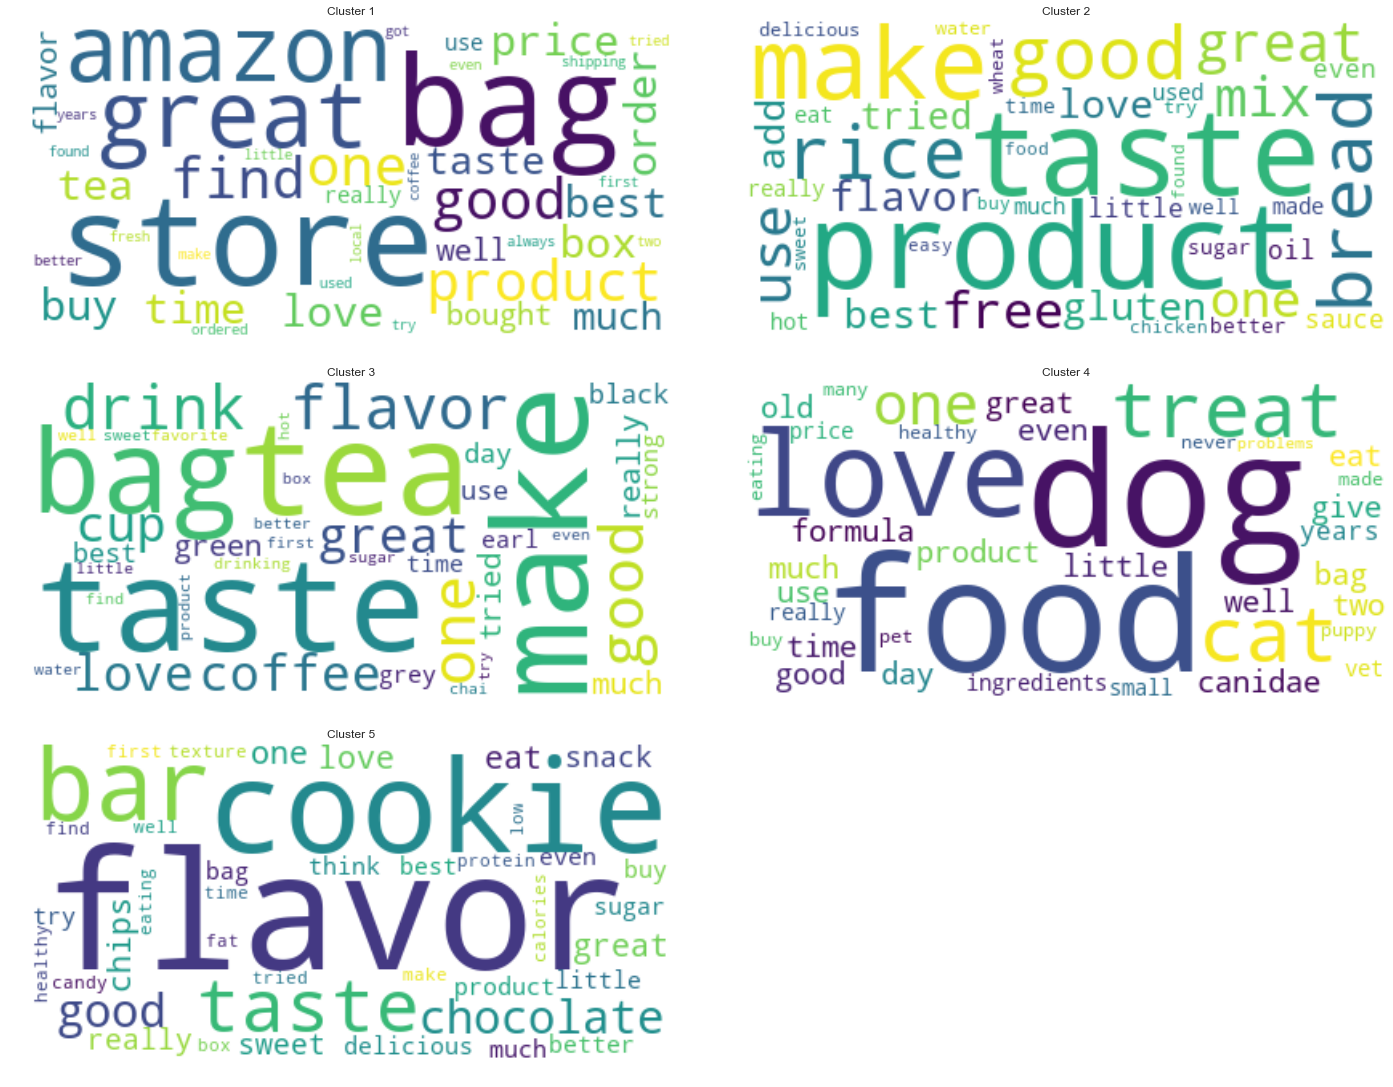

In [203]:
print("="*100)
print("Wordclouds for %d clusters"%k1)
print("="*100)
plot_wordclouds(list_of_sentance[:n_samples], labels_1, k1, n_words)
print("="*100)
print("Wordclouds for %d clusters"%k2)
print("="*100)
plot_wordclouds(list_of_sentance[:n_samples], labels_2, k2, n_words)

Here, we can see that when we choose to make <b>2 clusters</b>, one cluster represents daily food items like rice, bread, tea, coffee, chocolates, etc. and the reviews here possibly talk about how customers mostly love their taste, while the other cluster deals with mostly dog or other pet food, which seem to have been well received by the customers.<br>
When choosing to make 5 clusters, we find the reviews being grouped as below:<br>
<b>Cluster 1 :</b> Probably deals with the overall experience of ordering on Amazon and the pricing, compared to purchasing the same items from a store.<br>
<b>Cluster 2 :</b> Deals with some daily staples like rice, bread and their taste and ingredients, specifically things like being gluten-free, etc.<br>
<b>Cluster 3 :</b>Most likely deals with beverages like tea and coffee, their various types and how good they tasted.<br>
<b>Cluster 4 :</b> Mostly includes reviews on pet food for dogs and cats.<br>
<b>Cluster 5 :</b> Includes reviews on snacks like chips, cookies, chocolates and their various aspects like flavor, texture and how healthy they were.

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [204]:
k1 = 2; k2 = 5; n_samples = 10000; n_words = 50
agg1 = AgglomerativeClustering(n_clusters=k1)
labels_1 = agg1.fit_predict(tfidf_sent_vectors[:n_samples])

agg2 = AgglomerativeClustering(n_clusters=k2)
labels_2 = agg2.fit_predict(tfidf_sent_vectors[:n_samples])

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Wordclouds for 2 clusters


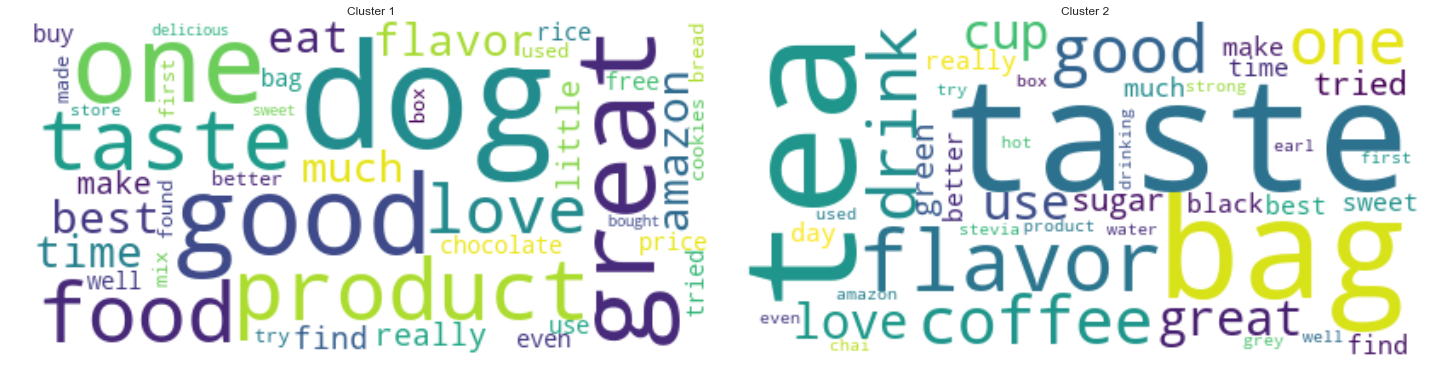

Wordclouds for 5 clusters


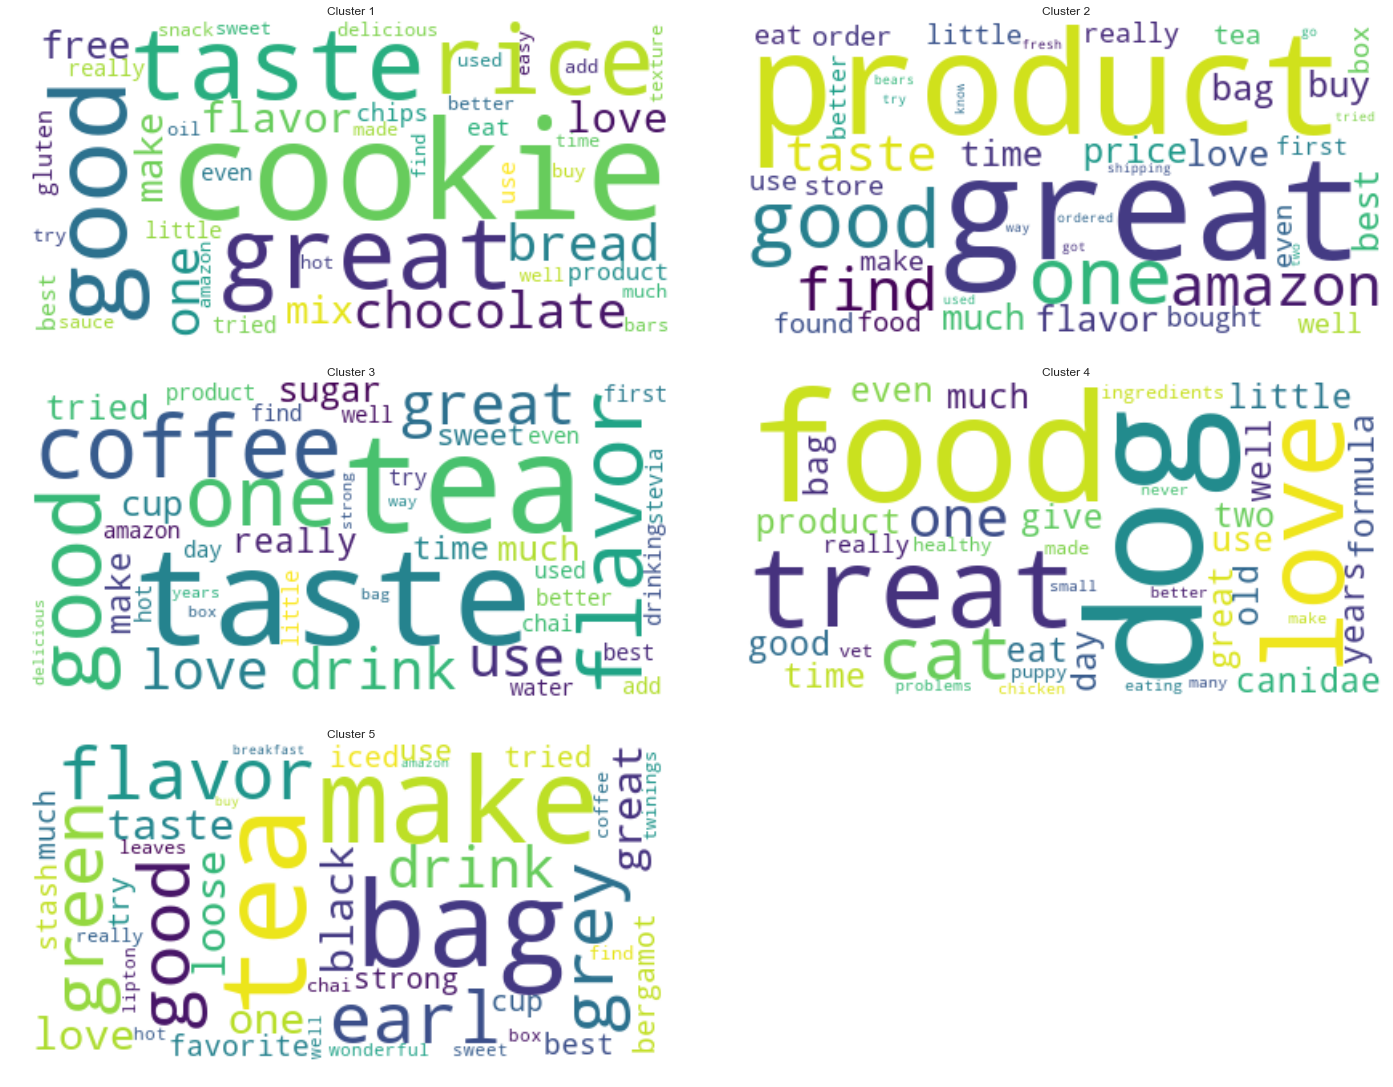

In [206]:
print("="*100)
print("Wordclouds for %d clusters"%k1)
print("="*100)
plot_wordclouds(list_of_sentance[:n_samples], labels_1, k1, n_words)
print("="*100)
print("Wordclouds for %d clusters"%k2)
print("="*100)
plot_wordclouds(list_of_sentance[:n_samples], labels_2, k2, n_words)

Here, we can see that when we choose to make <b>2 clusters</b>, one cluster represents beverages like tea and coffee and their different types, while the other deals mostly dog food as well as some daily eatables like cookies, bread and rice.<br>
When choosing to make 5 clusters, we find the reviews being grouped as below:<br>
<b>Cluster 1 :</b> Deals with some daily staples like rice, bread, chocolates and their taste and ingredients, specifically things like being gluten-free, etc.<br>
<b>Cluster 2 :</b> Probably deals with the overall quality of products purchased on Amazon, its pricing, and how well it meets their expectations.<br>
<b>Cluster 3 :</b> Includes taste reviews of both tea and coffee, how well the customers liked them and details of how they had them,i.e. with  sugar or stevia, hot water, etc.<br>
<b>Cluster 4 :</b> Mostly includes reviews on pet food for dogs and cats.<br>
<b>Cluster 5 :</b> Deals only with all kinds of tea like iced tea, chai, black tea, green tea, earl grey tea, etc. and how well they tasted.<br>

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

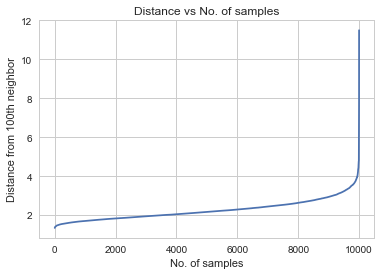

In [197]:
minPts = 100
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = minPts).fit(sent_vectors[:10000])
# Create distance matrix for all points(shape - n*n)
distances, indices = nbrs.kneighbors(sent_vectors[:10000])
# Sort distances to 100th neighbor for each point 
distances = sorted(distances[:, minPts - 1])
plt.style.use('seaborn-whitegrid')
plt.plot(distances)
plt.xlabel('No. of samples')
plt.ylabel('Distance from {}th neighbor'.format(minPts))
plt.title('Distance vs No. of samples')
plt.show()

In [205]:
clustering = DBSCAN(min_samples=minPts, eps=3.5, n_jobs=-1)
clusters = clustering.fit_predict(sent_vectors[:10000])
print(set(clusters))
print("No. of Core points:", clustering.components_.shape[0])
print("No. of Noise points: ", np.where(clusters == -1)[0].shape[0])
print("Silhouette Coefficient : %.3f"%metrics.silhouette_score(sent_vectors[:10000], clusters))

{0, -1}
No. of Core points: 9743
No. of Noise points:  19
Silhouette Coefficient : 0.476


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

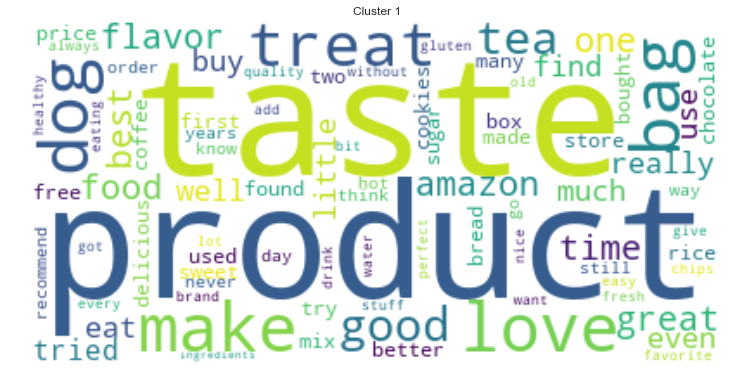

In [189]:
plot_wordclouds(list_sent=list_of_sentance[:10000], labels=clusters, n_clusters=1, n=100)

Since there is only one cluster, it looks like it deals mostly with the purchased product's taste and quality, and mentions all types of food products purchased from Amazon by customers, including pet food, beverages like tea and sweet drinks, snacks and cookies.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

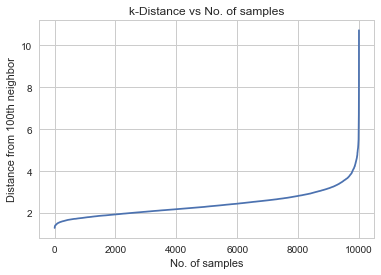

In [191]:
minPts = 100
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = minPts).fit(tfidf_sent_vectors[:10000])
# Create distance matrix for all points(shape - n*n)
distances, indices = nbrs.kneighbors(tfidf_sent_vectors[:10000])
# Sort distances to 100th neighbor for each point 
distances = sorted(distances[:, minPts - 1])
plt.style.use('seaborn-whitegrid')
plt.plot(distances)
plt.xlabel('No. of samples')
plt.ylabel('Distance from {}th neighbor'.format(minPts))
plt.title('k-Distance vs No. of samples')
plt.show()

In [204]:
clustering = DBSCAN(min_samples=minPts, eps=3.5, n_jobs=-1)
clusters = clustering.fit_predict(tfidf_sent_vectors[:10000])
print(set(clusters))
print("No. of Core points:", clustering.components_.shape[0])
print("No. of Noise points: ", np.where(clusters == -1)[0].shape[0])
print("Silhouette Coefficient : %.3f"%metrics.silhouette_score(tfidf_sent_vectors[:10000], clusters))

{0, -1}
No. of Core points: 9457
No. of Noise points:  39
Silhouette Coefficient : 0.419


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

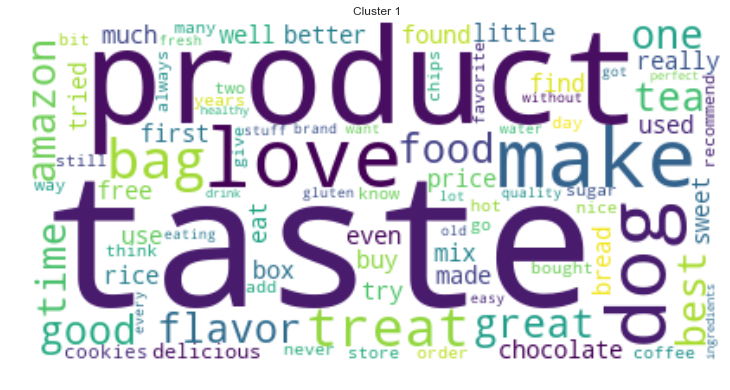

In [196]:
plot_wordclouds(list_sent=list_of_sentance[:10000], labels=clusters, n_clusters=1, n=100)

Since there is only one cluster, it looks like it deals mostly with the purchased product's taste and quality, and mentions all types of food products purchased from Amazon by customers, including pet food, beverages like tea and sweet drinks, chocolates, snacks and cookies.

# [6] Conclusions

In [198]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Clustering Algorithm", "No. of Clusters made", "Hyperparameters"]
x.add_row(["BoW", "KMeans", "6", ""])
x.add_row(["TFIDF", "KMeans", "8", ""])
x.add_row(["Avg-W2V", "KMeans", "8", ""])
x.add_row(["TFIDF-W2V", "KMeans", "9", ""])
x.add_row(["Avg-W2V", "Agglomerative", "2, 5", ""])
x.add_row(["TFIDF-W2V", "Agglomerative", "2, 5", ""])
x.add_row(["Avg-W2V", "DBSCAN", "1", "MinPts = 100, eps = 3.5"])
x.add_row(["TFIDF-W2V", "DBSCAN", "1", "MinPts = 100, eps = 3.5"])
print(x)

+------------+----------------------+----------------------+-------------------------+
| Vectorizer | Clustering Algorithm | No. of Clusters made |     Hyperparameters     |
+------------+----------------------+----------------------+-------------------------+
|    BoW     |        KMeans        |          6           |                         |
|   TFIDF    |        KMeans        |          8           |                         |
|  Avg-W2V   |        KMeans        |          8           |                         |
| TFIDF-W2V  |        KMeans        |          9           |                         |
|  Avg-W2V   |    Agglomerative     |         2, 5         |                         |
| TFIDF-W2V  |    Agglomerative     |         2, 5         |                         |
|  Avg-W2V   |        DBSCAN        |          1           | MinPts = 100, eps = 3.5 |
| TFIDF-W2V  |        DBSCAN        |          1           | MinPts = 100, eps = 3.5 |
+------------+----------------------+------